In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/FoodSeg103"

/content/drive/MyDrive/Colab Notebooks/FoodSeg103


In [3]:
!pip -q install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip -q install transformers==4.44.2 albumentations==1.4.8 opencv-python tqdm

In [4]:
!pip install -U albumentations==1.4.7 albucore==0.0.8

  Using cached albumentations-1.4.7-py3-none-any.whl.metadata (37 kB)
Using cached albumentations-1.4.7-py3-none-any.whl (155 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.8
    Uninstalling albumentations-1.4.8:
      Successfully uninstalled albumentations-1.4.8


In [5]:
import torch
import torch.nn as nn
import os
from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

In [6]:
BATCH_SIZE = 8
EPOCHS = 10

In [7]:
# ----------------------------
# Dataset 정의
# ----------------------------
class FoodSeg103(Dataset):
    IMG_EXTS  = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
    MASK_EXTS = {'.png', '.bmp', '.tif', '.tiff'}

    def __init__(self, img_dir, mask_dir, img_transform=None, size=(256, 256)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.size = size

        imgs = [f for f in os.listdir(img_dir)
                if not f.startswith('.') and os.path.splitext(f)[1].lower() in self.IMG_EXTS]
        masks = [f for f in os.listdir(mask_dir)
                 if not f.startswith('.') and os.path.splitext(f)[1].lower() in self.MASK_EXTS]

        def to_map(files):
            d = {}
            for f in files:
                stem, ext = os.path.splitext(f)
                d.setdefault(stem, []).append(f)
            return d

        img_map  = to_map(imgs)
        mask_map = to_map(masks)

        common_stems = sorted(set(img_map.keys()) & set(mask_map.keys()))
        if not common_stems:
            raise RuntimeError("No matching image/mask pairs found.")

        self.data = []
        for stem in common_stems:
            img_file  = sorted(img_map[stem])[0]
            mask_file = sorted(mask_map[stem])[0]
            self.data.append((os.path.join(img_dir, img_file),
                              os.path.join(mask_dir, mask_file)))

        self._to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def _read_image_rgb(self, path):
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Failed to read image: {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

    def _read_mask_gray(self, path):
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Failed to read mask: {path}")
        return mask

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        img  = self._read_image_rgb(img_path)
        mask = self._read_mask_gray(mask_path)

        if self.size is not None:
            w, h = self.size
            img  = cv2.resize(img,  (w, h), interpolation=cv2.INTER_LINEAR)
            mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

        if self.img_transform is not None:
            img_pil = Image.fromarray(img)
            img = self.img_transform(img_pil)
        else:
            img = self._to_tensor(img)

        mask = torch.as_tensor(np.array(mask), dtype=torch.long)
        return img, mask

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
IMG_SIZE = 512

# 학습/검증/테스트 동일
base_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LINEAR),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class FoodSeg103Alb(FoodSeg103):
    def __init__(self, img_dir, mask_dir, aug):
        super().__init__(img_dir, mask_dir, img_transform=None, size=None)
        self.aug = aug
    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]
        img  = self._read_image_rgb(img_path)
        mask = self._read_mask_gray(mask_path)
        out = self.aug(image=img, mask=mask)
        img  = out["image"]
        mask = torch.as_tensor(out["mask"], dtype=torch.long)
        return img, mask

# 증강 대신 최소 전처리만
train_dataset = FoodSeg103Alb('data/img_dir/train','data/ann_dir/train', aug=base_aug)
val_dataset   = FoodSeg103Alb('data/img_dir/train','data/ann_dir/train', aug=base_aug)
test_dataset  = FoodSeg103Alb('data/img_dir/test','data/ann_dir/test',  aug=base_aug)

In [9]:

train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, validation_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                            num_workers=0,pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0,pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=0,pin_memory=True,)

In [10]:
# ----------------------------
# IoU 계산 함수
# ----------------------------
def calculate_iou(pred, target, num_classes):
    ious = []
    pred = pred.reshape(-1)
    target = target.reshape(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

In [11]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# ----------------------------
# SegFormer 모델 정의
# ----------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")   # 코랩 GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")    # 맥북 M1/M2 GPU
else:
    device = torch.device("cpu")    # CPU fallback

print("Using device:", device)

NUM_CLASSES = 104
config = SegformerConfig.from_pretrained("nvidia/segformer-b2-finetuned-ade-512-512")
config.num_labels = NUM_CLASSES
config.id2label = {i: str(i) for i in range(NUM_CLASSES)}
config.label2id = {str(i): i for i in range(NUM_CLASSES)}
config.label_ignore_index = 255
config.semantic_loss_ignore_index = 255
config.reduce_labels = False

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    config=config,
    ignore_mismatched_sizes=True
).to(device)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([104, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([104]) in the model instantiated
You

In [12]:
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

# 채널라스트
model = model.to(memory_format=torch.channels_last)
for m in model.modules():
    if isinstance(m, torch.nn.Conv2d):
      m.to(memory_format=torch.channels_last)
# Fused AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=0.01, fused=True)

In [13]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5)

In [14]:
def visualize_img(img, mask):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    img_plot = img.permute(1, 2, 0)
    axes[0].imshow(img_plot)
    axes[0].set_title("Image")
    axes[1].imshow(mask)
    axes[1].set_title("Mask")

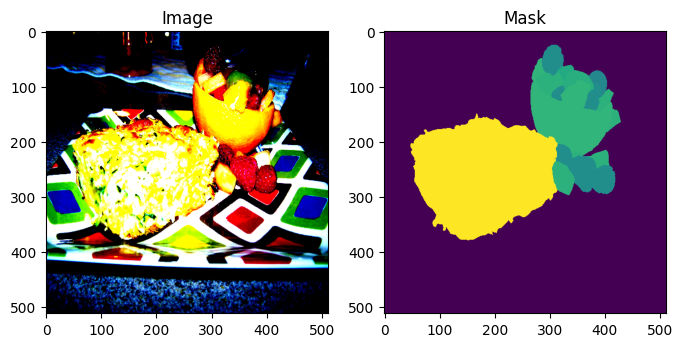

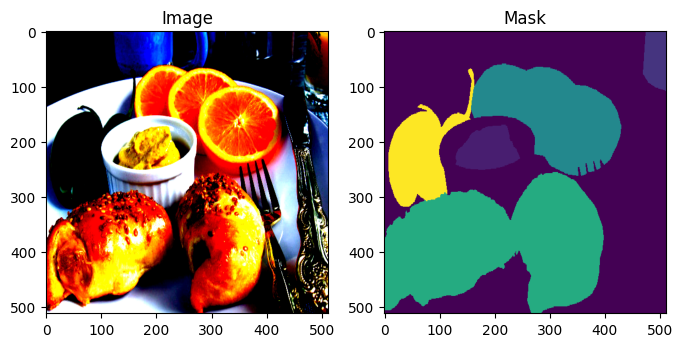

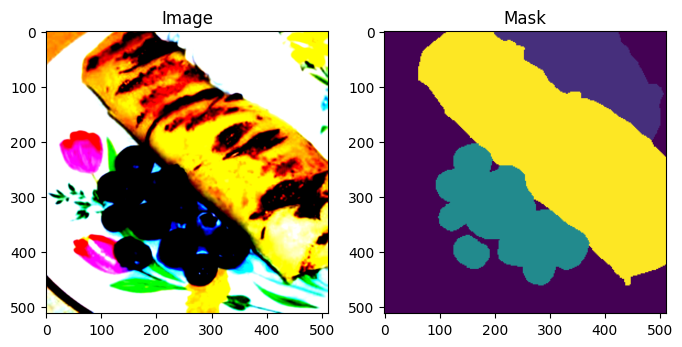

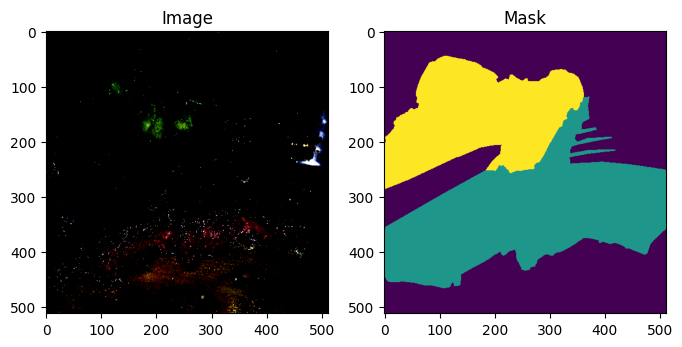

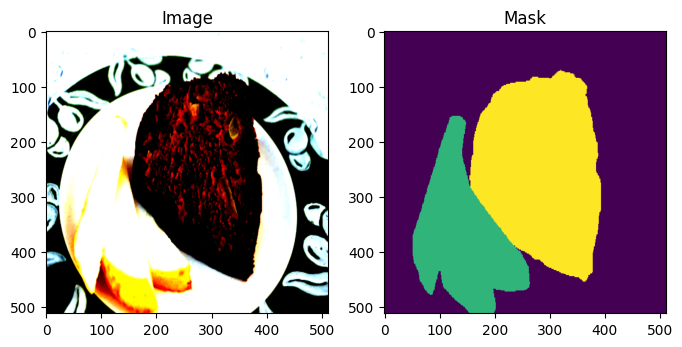

In [15]:
for i in range(100,105):
    img, mask = train_dataset[i]
    visualize_img(img, mask)

In [16]:
img, mask = train_dataset[0]
uniques = np.unique(mask.numpy())
print("mask unique:", uniques[:50], " ... ", len(uniques))

mask unique: [  0  24  67  73 102]  ...  5


In [17]:
def dice_loss(logits, target, ignore_index=255, eps=1e-6):
    """
    logits: (B, C, H, W), raw scores
    target: (B, H, W),    long class ids
    """
    logits = logits.float()
    target = target.long()
    B, C, H, W = logits.shape

    # 유효 픽셀만 사용
    valid = (target != ignore_index)           # (B,H,W)
    if not valid.any():
        return logits.new_tensor(0.0)

    # 확률로 변환 후 유효 픽셀만 (N, C)
    probs = F.softmax(logits, dim=1)           # (B,C,H,W)
    probs = probs.permute(0, 2, 3, 1)[valid]   # (N, C)
    target_v = target[valid]                   # (N,)

    # 각 클래스별 합: Σ_y p_c(y) 와 Σ_y 1[target=y=c]
    probs_sum  = probs.sum(dim=0)                             # (C,)
    target_sum = torch.bincount(target_v, minlength=C).float().to(probs.device)  # (C,)

    # 교집합: 진짜 클래스의 확률을 그 클래스 버킷에 합치기
    p_true = probs[torch.arange(probs.shape[0], device=probs.device), target_v]  # (N,)
    inter = torch.zeros(C, device=probs.device).scatter_add_(0, target_v, p_true)  # (C,)

    dice_c = (2 * inter + eps) / (probs_sum + target_sum + eps)  # (C,)
    non_empty = target_sum > 0
    if non_empty.any():
        return 1.0 - dice_c[non_empty].mean()
    else:
        return logits.new_tensor(0.0)

def seg_loss(logits_up, masks, w_dice=0.3, ignore_index=255):
    ce = F.cross_entropy(logits_up, masks, ignore_index=ignore_index)
    dc = dice_loss(logits_up, masks, ignore_index=ignore_index)
    return (1 - w_dice) * ce + w_dice * dc

In [18]:
import torch
import torch.nn.functional as F

def cross_entropy_2d_safe(logits, targets, ignore_index=255):
    """
    logits: (B, C, H, W)
    targets: (B, H, W)  int64
    - logits을 (N,C), targets를 (N,)으로 reshape 만 사용
    - ignore_index는 마스크로 직접 제외
    """
    B, C, H, W = logits.shape

    # (B,C,H,W) -> (B,H,W,C) -> (N,C)
    logp = F.log_softmax(logits, dim=1)                       # (B,C,H,W)
    logp = logp.permute(0, 2, 3, 1).contiguous().reshape(-1, C)

    # (B,H,W) -> (N,)
    tgt  = targets.contiguous().reshape(-1)

    # 유효 픽셀만 선택
    mask = (tgt != ignore_index)
    if mask.sum() == 0:
        return logits.new_tensor(0.0, requires_grad=True)

    logp = logp[mask]             # (M,C)
    tgt  = tgt[mask]              # (M,)

    # take_along_dim 으로 한 class의 logprob 선택 (고급 인덱싱 최소화)
    gathered = torch.take_along_dim(
        logp, tgt.unsqueeze(1), dim=1
    ).squeeze(1)                  # (M,)

    loss = -gathered.mean()
    return loss

In [32]:
import torch.nn.functional as F
import numpy as np

def evaluate_miou(model, data_loader, device, num_classes, log_interval=100):
    model.eval()
    miou_scores = []
    total = len(data_loader.dataset)
    processed = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(data_loader, 1):
            images = images.to(device).float()
            masks  = masks.to(device).long()   # (B,H,W)

            outputs = model(images)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs
            logits = F.interpolate(logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(logits, dim=1)

            for pred, target in zip(preds, masks):
                miou = calculate_iou(pred.cpu(), target.cpu(), num_classes)
                miou_scores.append(miou)
                processed += 1

            # 일정 간격마다 로그 출력
            if batch_idx % log_interval == 0:
                cur_mean = float(np.nanmean(miou_scores))
                print(f"[Eval] Processed {processed}/{total} images "
                      f"(Batch {batch_idx}/{len(data_loader)}) - Current mIoU: {cur_mean:.4f}")

    final_miou = float(np.nanmean(miou_scores))
    print(f"[Eval] Done! Final mIoU on {total} images: {final_miou:.4f}")
    return final_miou

In [20]:
# 파라미터 수 출력
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 27,426,600
Trainable parameters: 27,426,600


In [25]:
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

ce_ignore = 255
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    print(f"\n[ Epoch {epoch+1}/{EPOCHS} ]")

    # ---------- Train ----------
    for batch_idx, (images, masks) in enumerate(train_loader, start=1):
        images = images.to(device).contiguous()
        masks  = masks.to(device, dtype=torch.long).contiguous()

        outputs = model(pixel_values=images)
        logits  = outputs.logits.contiguous()  # (B,C,h,w)
        #masks_resized = torch.nn.functional.interpolate(
        #    masks.unsqueeze(1).float(),
        #    size=logits.shape[2:],  # (H, W)
        #    mode="nearest"
        #).squeeze(1).long().contiguous()
        # ✅ 로짓을 GT 마스크 크기로 업샘플 (표준/안정)
        logits = F.interpolate(
            logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
        ).contiguous()

        # ✅ MPS-세이프 CE
        loss = cross_entropy_2d_safe(logits, masks ,ignore_index=ce_ignore)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch_idx % 50 == 0 or batch_idx == len(train_loader):
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    avg_train_loss = running_loss / len(train_loader)

    # ---------- Val ----------
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).contiguous()
            masks  = masks.to(device, dtype=torch.long).contiguous()

            outputs = model(pixel_values=images)
            logits  = outputs.logits.contiguous()
            #masks_resized = torch.nn.functional.interpolate(
            #    masks.unsqueeze(1).float(),
            #    size=logits.shape[2:],  # (H, W)
            #    mode="nearest"
            #).squeeze(1).long().contiguous()
            logits = F.interpolate(
                logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            ).contiguous()

            loss = cross_entropy_2d_safe(logits, masks, ignore_index=ce_ignore)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).contiguous()

            val_iou += calculate_iou(
                preds.cpu(), masks.cpu(), NUM_CLASSES
            )
            correct += (preds == masks).sum().item()
            total   += masks.numel()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou  = val_iou / len(val_loader)
    val_acc      = correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} "
          f"- train_loss: {avg_train_loss:.4f} "
          f"- val_loss: {avg_val_loss:.4f} "
          f"- acc: {val_acc:.4f} "
          f"- mIoU: {avg_val_iou:.4f}")


[ Epoch 1/10 ]
  Batch 50/499 - Loss: 2.6904
  Batch 100/499 - Loss: 2.4135
  Batch 150/499 - Loss: 2.2371
  Batch 200/499 - Loss: 2.0335
  Batch 250/499 - Loss: 1.8860
  Batch 300/499 - Loss: 2.0430
  Batch 350/499 - Loss: 1.9591
  Batch 400/499 - Loss: 2.1612
  Batch 450/499 - Loss: 1.3938
  Batch 499/499 - Loss: 1.3313
Epoch 1/10 - train_loss: 2.1223 - val_loss: 1.5735 - acc: 0.6452 - mIoU: 0.1545

[ Epoch 2/10 ]
  Batch 50/499 - Loss: 1.4474
  Batch 100/499 - Loss: 1.4804
  Batch 150/499 - Loss: 1.2993
  Batch 200/499 - Loss: 1.6170
  Batch 250/499 - Loss: 1.3496
  Batch 300/499 - Loss: 1.6711
  Batch 350/499 - Loss: 1.3329
  Batch 400/499 - Loss: 1.2168
  Batch 450/499 - Loss: 1.3464
  Batch 499/499 - Loss: 1.6253
Epoch 2/10 - train_loss: 1.4358 - val_loss: 1.2132 - acc: 0.7000 - mIoU: 0.2285

[ Epoch 3/10 ]
  Batch 50/499 - Loss: 1.1330
  Batch 100/499 - Loss: 1.3260
  Batch 150/499 - Loss: 1.3479
  Batch 200/499 - Loss: 1.2448
  Batch 250/499 - Loss: 1.1734
  Batch 300/499 - Lo

In [28]:
torch.save(model.state_dict(), "checkpoints/segformer_1.pth")

In [33]:
test_miou = evaluate_miou(model, test_loader, device, 104, log_interval=50)
print(f"[Test] mIoU: {test_miou:.4f}")

[Eval] Processed 400/2135 images (Batch 50/267) - Current mIoU: 0.4077
[Eval] Processed 800/2135 images (Batch 100/267) - Current mIoU: 0.4247
[Eval] Processed 1200/2135 images (Batch 150/267) - Current mIoU: 0.4195
[Eval] Processed 1600/2135 images (Batch 200/267) - Current mIoU: 0.4234
[Eval] Processed 2000/2135 images (Batch 250/267) - Current mIoU: 0.4154
[Eval] Done! Final mIoU on 2135 images: 0.4043
[Test] mIoU: 0.4043


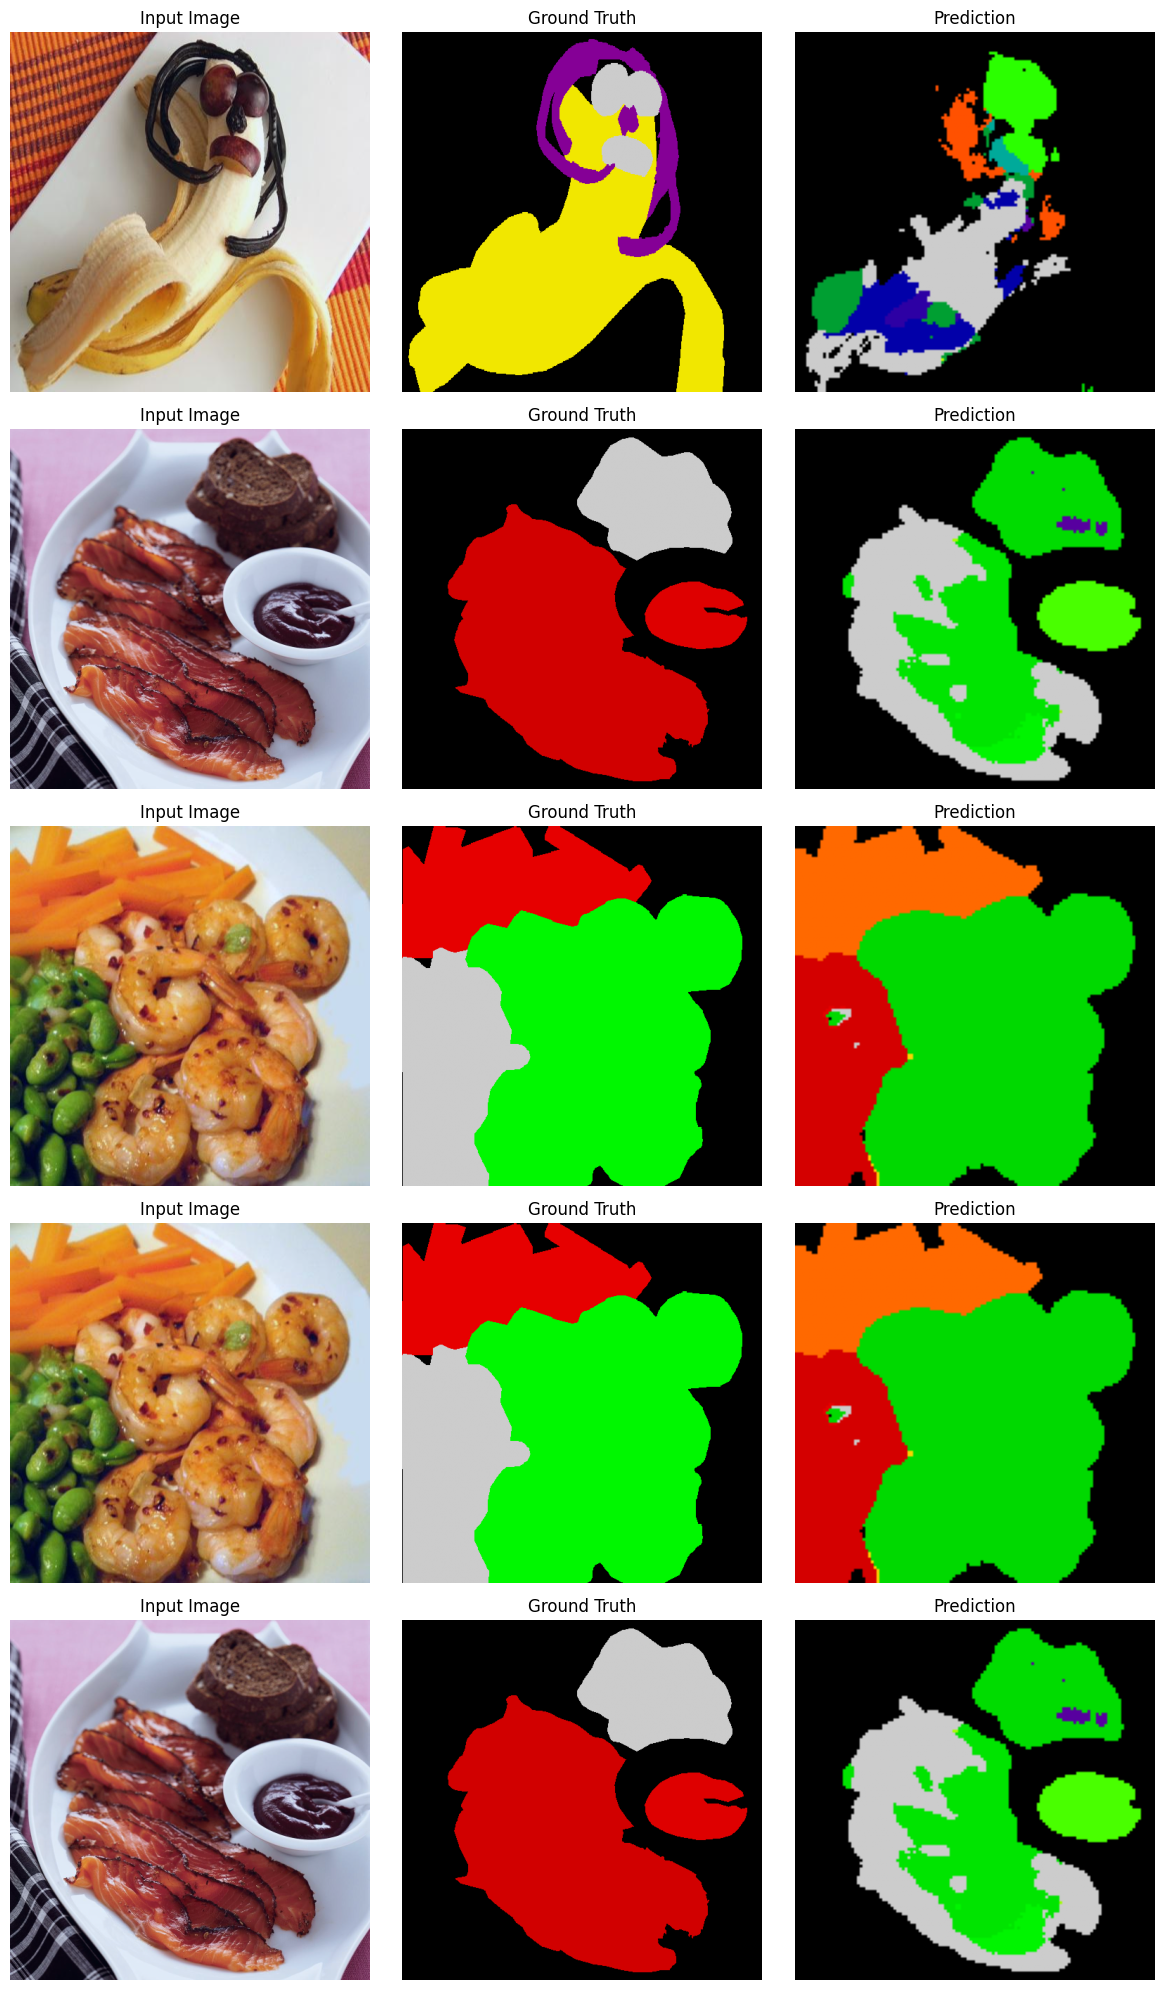

In [36]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, loader, device, num_samples=3, random_sample=False):
    model.eval()
    images, masks = next(iter(loader))  # 배치 하나만 뽑음
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        out = model(images)
        logits = out.logits if hasattr(out, "logits") else out
        preds = torch.argmax(logits, dim=1)

    # 샘플 선택
    if random_sample:
        idxs = torch.randint(0, images.shape[0], (min(num_samples, images.shape[0]),))
    else:
        idxs = list(range(min(num_samples, images.shape[0])))

    # 하나의 그림에 (샘플 수 × 3) 서브플롯 생성
    fig, axes = plt.subplots(len(idxs), 3, figsize=(12, 4 * len(idxs)))

    if len(idxs) == 1:
        axes = [axes]  # 1행일 경우 2차원 배열이 아니라 리스트로 변환

    for row, i in enumerate(idxs):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        mask_true = masks[i].cpu().numpy()
        mask_pred = preds[i].cpu().numpy()

        axes[row][0].imshow((img - img.min()) / (img.max() - img.min()))
        axes[row][0].set_title("Input Image")
        axes[row][1].imshow(mask_true, cmap="nipy_spectral")
        axes[row][1].set_title("Ground Truth")
        axes[row][2].imshow(mask_pred, cmap="nipy_spectral")
        axes[row][2].set_title("Prediction")

        for ax in axes[row]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# 실행
visualize_predictions(model, test_loader, device, num_samples=5, random_sample=True)